In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from matplotlib import rcParams
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
df_tv = pd.read_csv('data/train.csv')
df_tt = pd.read_csv('data/test.csv')

In [3]:
df_tv.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
df_tt.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [5]:
df_tv['FamilySize'] = df_tv.SibSp + df_tv.Parch + 1
df_tt['FamilySize'] = df_tt.SibSp + df_tt.Parch + 1
df_tv.Fare /= df_tv.FamilySize
df_tt.Fare /= df_tt.FamilySize

df_tv.drop(['SibSp', 'Parch'], axis=1, inplace=True)
df_tt.drop(['SibSp', 'Parch'], axis=1, inplace=True)

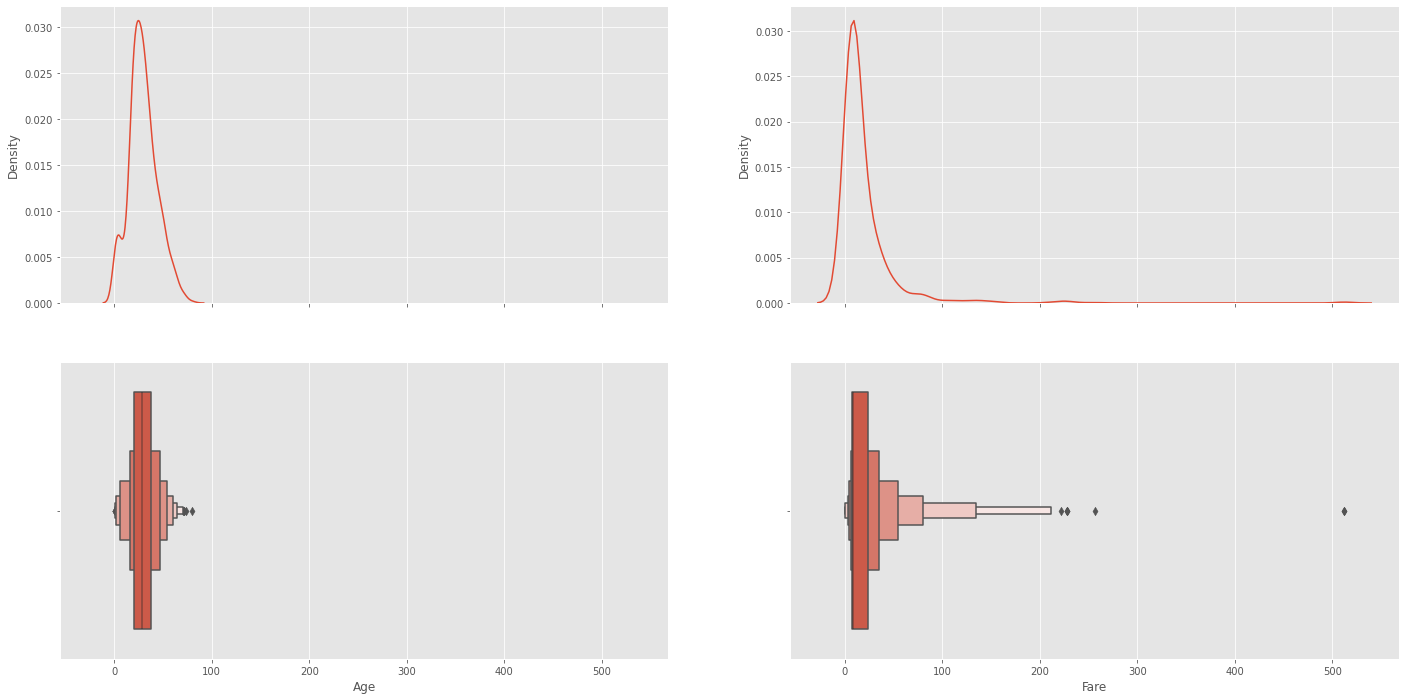

In [6]:
_, axes = plt.subplots(2, 2, figsize=(24, 12), sharex=True)
sns.kdeplot(data=df_tv, x='Age', ax=axes[0, 0])
sns.kdeplot(data=df_tv, x='Fare', ax=axes[0, 1])
sns.boxenplot(data=df_tv, x='Age', ax=axes[1, 0])
sns.boxenplot(data=df_tv, x='Fare', ax=axes[1, 1])
plt.show()

In [7]:
df_tv[df_tv.Fare < 220].Fare.median()

8.08125

In [8]:
df_tv.Fare = df_tv.Fare.apply(lambda x: x if x < 220 else 8)
df_tt.Fare = df_tt.Fare.apply(lambda x: x if x < 220 else 8)

In [9]:
age_imputer = SimpleImputer(strategy='median')
df_tv[['Age', 'Fare']] = age_imputer.fit_transform(df_tv[['Age', 'Fare']])
df_tt[['Age', 'Fare']] = age_imputer.transform(df_tt[['Age', 'Fare']])

In [10]:
df_tv.Cabin = df_tv.Cabin.apply(lambda x: np.nan if x is np.nan else x[0])
df_tt.Cabin = df_tt.Cabin.apply(lambda x: np.nan if x is np.nan else x[0])

In [11]:
df_tv[['Fare', 'Cabin']].groupby('Cabin')['Fare'].agg('mean').sort_values()

Cabin
G     4.963021
F     9.050213
E    29.177041
A    32.768100
D    34.384263
T    35.500000
C    44.929848
B    53.369060
Name: Fare, dtype: float64

In [12]:
fare_cuts_for_cabin = [-np.inf, 7, 19, 31, 33, 35, 40, 49, np.inf]
cabins_na_tv = pd.cut(df_tv[df_tv.Cabin.isna()].Fare, bins=fare_cuts_for_cabin, labels=['G', 'F', 'E', 'A', 'D', 'T', 'C', 'B'])
cabins_na_tt = pd.cut(df_tt[df_tt.Cabin.isna()].Fare, bins=fare_cuts_for_cabin, labels=['G', 'F', 'E', 'A', 'D', 'T', 'C', 'B'])
df_tv.loc[cabins_na_tv.index, 'Cabin'] = cabins_na_tv
df_tt.loc[cabins_na_tt.index, 'Cabin'] = cabins_na_tt

In [13]:
df_tv[df_tv.Embarked.isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,FamilySize
61,62,1,1,"Icard, Miss. Amelie",female,38.0,113572,80.0,B,NaN,1
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,113572,80.0,B,NaN,1


In [14]:
embarked_tv_na_mask = (df_tv.Pclass == 1) & (df_tv.Cabin == 'B') & (df_tv.Sex == 'female') & (df_tv.FamilySize == 1) & (~df_tv.Embarked.isna())
df_tv[embarked_tv_na_mask].groupby('Embarked')['Fare'].median()

Embarked
C    79.2
S    86.5
Name: Fare, dtype: float64

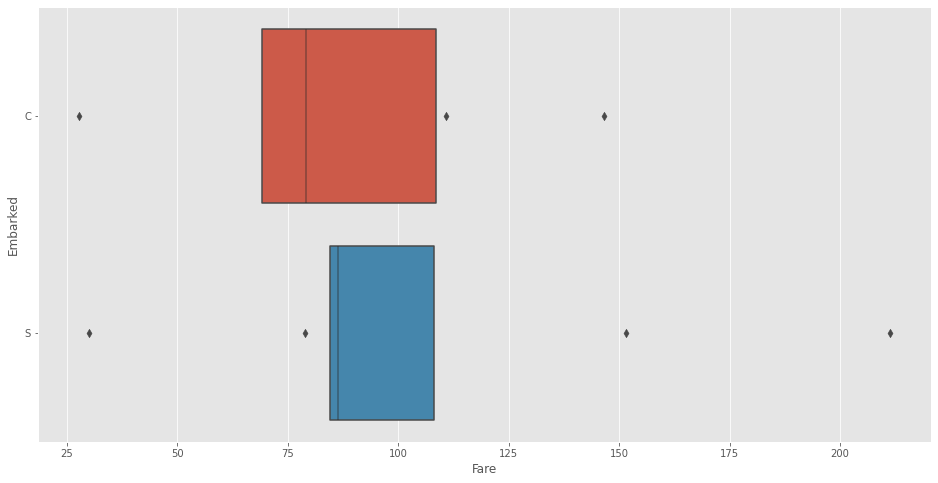

In [15]:
_, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.boxenplot(data=df_tv[embarked_tv_na_mask], x='Fare', y='Embarked', ax=ax)
plt.show()

In [16]:
df_tv.Embarked.fillna('C', inplace=True)

In [17]:
def get_title_from_name(name: str):
    _, first_name = name.split(', ')
    title, *_ = first_name.split()
    return title[:-1]

In [18]:
title_tv = df_tv.Name.apply(get_title_from_name)
title_tt = df_tt.Name.apply(get_title_from_name)
title_tv.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
th            1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Name, dtype: int64

In [19]:
title_tv = title_tv.apply(lambda x: x if x in ['Mr', 'Miss', 'Mrs', 'Master'] else 'Others')
title_tt = title_tt.apply(lambda x: x if x in ['Mr', 'Miss', 'Mrs', 'Master'] else 'Others')
df_tv['Title'] = title_tv
df_tt['Title'] = title_tt
df_tv.drop('Name', axis=1, inplace=True)
df_tt.drop('Name', axis=1, inplace=True)

In [20]:
df_tv.drop('Ticket', inplace=True, axis=1)
df_tt.drop('Ticket', inplace=True, axis=1)

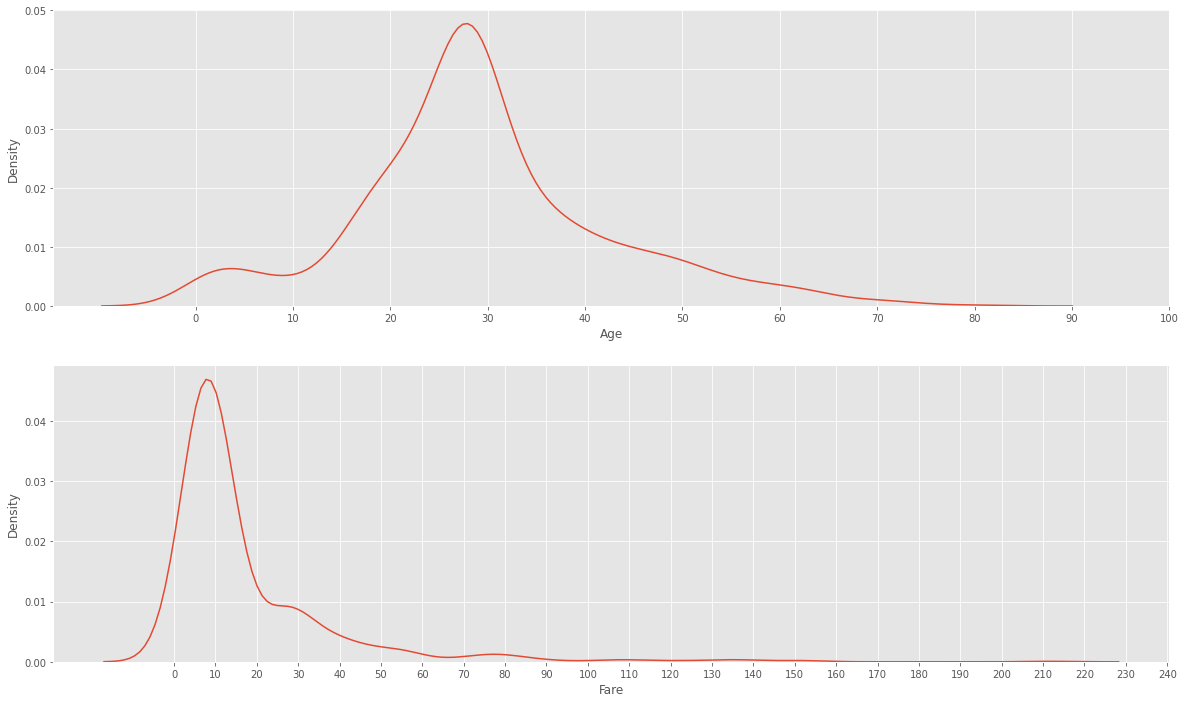

In [21]:
_, axes = plt.subplots(2, 1, figsize=(20, 12))
sns.kdeplot(data=df_tv, x='Age', ax=axes[0])
axes[0].set_xlabel('Age')
axes[0].set_xticks(np.arange(0, 110, 10, dtype=int))
sns.kdeplot(data=df_tv, x='Fare', ax=axes[1])
axes[1].set_xlabel('Fare')
axes[1].set_xticks(np.arange(0, 250, 10, dtype=int))
plt.show()

In [22]:
age_cuts = [-np.inf, 10, 45, 65, np.inf]
fare_cuts = [-np.inf, 25, 45, 95, np.inf]
df_tv.Age = pd.cut(df_tv.Age, bins=age_cuts, labels=[1, 2, 3, 4]).astype(int)
df_tt.Age = pd.cut(df_tt.Age, bins=age_cuts, labels=[1, 2, 3, 4]).astype(int)
df_tv.Fare = pd.cut(df_tv.Fare, bins=fare_cuts, labels=[1, 2, 3, 4]).astype(int)
df_tt.Fare = pd.cut(df_tt.Fare, bins=fare_cuts, labels=[1, 2, 3, 4]).astype(int)


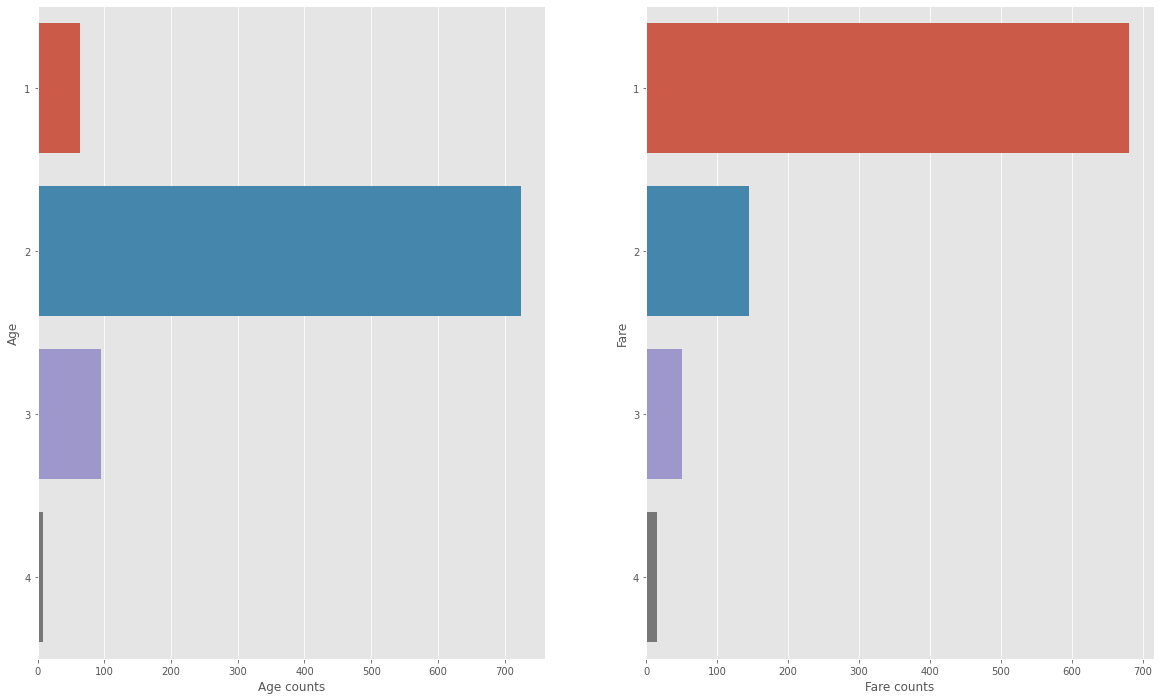

In [23]:
_, axes = plt.subplots(1, 2, figsize=(20, 12))
sns.countplot(data=df_tv, y='Age', ax=axes[0])
sns.countplot(data=df_tv, y='Fare', ax=axes[1])
axes[0].set_xlabel('Age counts')
axes[1].set_xlabel('Fare counts')
plt.show()

In [24]:
ohe = OneHotEncoder(drop='first')
cat_columns = df_tv.select_dtypes(include=['object']).columns
ohe.fit(df_tv[cat_columns])
enc_columns = ohe.get_feature_names_out().tolist()
df_tv[enc_columns] = ohe.transform(df_tv[cat_columns]).toarray()
df_tt[enc_columns] = ohe.transform(df_tt[cat_columns]).toarray()
df_tv.drop(cat_columns, axis=1, inplace=True)
df_tt.drop(cat_columns, axis=1, inplace=True)

In [25]:
df_tv.to_csv('data/train_preprocessed.csv', index=False)
df_tt.to_csv('data/test_preprocessed.csv', index=False)